In [58]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [59]:
path = '/Users/nielsaugustdavidsen/Documents/Data/era5'
input_files_msl = [f for f in os.listdir(path) if f.endswith('.nc') and 'mean_sea_level_pressure' in f]
input_files_msl

['era5_1943_mean_sea_level_pressure.nc',
 'era5_1944_mean_sea_level_pressure.nc',
 'era5_1942_mean_sea_level_pressure.nc',
 'era5_1940_mean_sea_level_pressure.nc',
 'era5_1941_mean_sea_level_pressure.nc']

In [60]:
input_files_msl.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
input_files_msl

['era5_1940_mean_sea_level_pressure.nc',
 'era5_1941_mean_sea_level_pressure.nc',
 'era5_1942_mean_sea_level_pressure.nc',
 'era5_1943_mean_sea_level_pressure.nc',
 'era5_1944_mean_sea_level_pressure.nc']

In [79]:
##merge the files from the list
file_paths_msl = [os.path.join(path, fname) for fname in input_files_msl]

# Then open all files with xarray
ds_msl = xr.open_mfdataset(file_paths_msl, combine='by_coords').sel(latitude=slice(70, 40.25 ), longitude=slice(-80, 21.75))

mean_msl = ds_msl.msl.mean(dim='valid_time')
std_msl = ds_msl.msl.std(dim='valid_time')

msl_norm = (ds_msl.msl - mean_msl) / std_msl

ds_msl['msl_norm'] = msl_norm

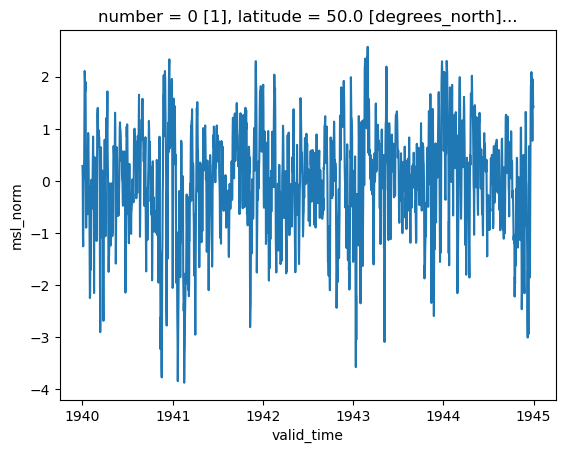

In [80]:
ds_msl.msl_norm.sel(longitude=0, latitude=50, method = 'nearest').plot()

In [81]:
msl_input = ds_msl.msl_norm.values
msl_input.shape

(1827, 120, 408)

['era5_1940_temperature_850hPa.nc', 'era5_1941_temperature_850hPa.nc', 'era5_1942_temperature_850hPa.nc', 'era5_1943_temperature_850hPa.nc', 'era5_1944_temperature_850hPa.nc']


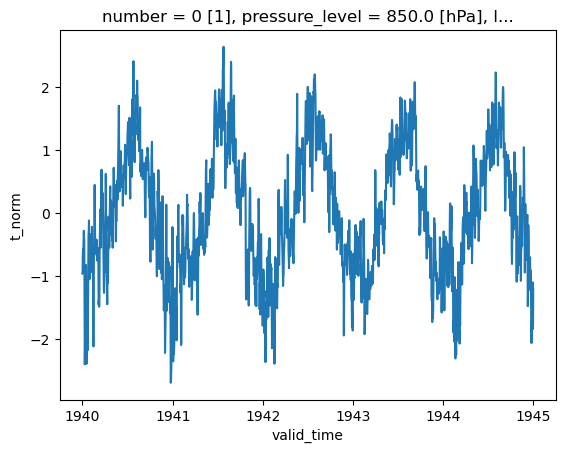

In [82]:
input_files_t850 = [f for f in os.listdir(path) if f.endswith('.nc') and '850' in f]
input_files_t850.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
print(input_files_t850)

file_paths_t850 = [os.path.join(path, fname) for fname in input_files_t850]
ds_t850 = xr.open_mfdataset(file_paths_t850, combine='by_coords').isel(pressure_level=0).sel(latitude=slice(70, 40.25), longitude=slice(-80, 21.75))

# Normalize temperature 't' at each grid point over time
# Calculate mean and std dev along time dimension
mean_t = ds_t850.t.mean(dim='valid_time')
std_t = ds_t850.t.std(dim='valid_time')

# Apply normalization
t_norm = (ds_t850.t - mean_t) / std_t

# Replace original temperature variable with normalized data (optional)
ds_t850['t_norm'] = t_norm

# Now plot the normalized time series at nearest grid point to lon=0, lat=0
ds_t850.t_norm.sel(longitude=0, latitude=0, method='nearest').plot()

t850_input = ds_t850.t_norm.values


In [83]:
target_prec = [f for f in os.listdir(path) if f.endswith('.nc') and 'total' in f]
target_prec.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
target_prec


['era5_1940_total_precipitation.nc',
 'era5_1941_total_precipitation.nc',
 'era5_1942_total_precipitation.nc',
 'era5_1943_total_precipitation.nc',
 'era5_1944_total_precipitation.nc']

(1827,)

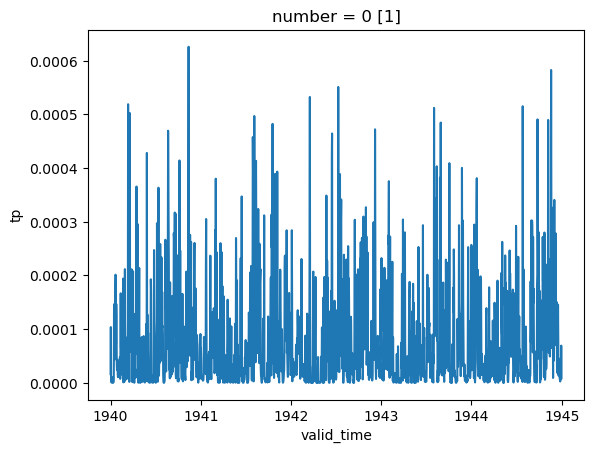

In [84]:
file_paths_prec = [os.path.join(path, fname) for fname in target_prec]
ds_prec = xr.open_mfdataset(file_paths_prec, combine='by_coords')
ds_prec = ds_prec.mean(dim= ['longitude', 'latitude'])
prec_target = ds_prec.tp.values
ds_prec.tp.plot()
prec_target.shape

In [85]:
import sys 

import torch
import torch.optim as optim
import torch.nn as nn
from torchinfo import summary
from torcheval.metrics.functional import binary_f1_score
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# import preprocessing as prep
# import postprocessing as post
# import training as train
# import models as mod
from sklearn.metrics import roc_curve, auc, recall_score, precision_score
import pickle
from torch.utils.data import TensorDataset, DataLoader



In [86]:
X = np.stack([t850_input, msl_input], axis=1)
X.shape

(1827, 2, 120, 408)

In [87]:
##import standard scaler
from sklearn.preprocessing import MinMaxScaler

In [88]:
print(X.shape)
##take 250 random samples from X to test the model
random_indices = np.random.choice(X.shape[0], size=250, replace=False)
# Create a boolean mask for test data
mask = np.zeros(X.shape[0], dtype=bool)
mask[random_indices] = True

# Split the data using the mask
X_test = X[mask]
X_train = X[~mask]
scaler = MinMaxScaler()

y_test = scaler.fit_transform(prec_target[mask].reshape(-1, 1))
y_train =scaler.fit_transform(prec_target[~mask].reshape(-1, 1))

# Check the shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)




(1827, 2, 120, 408)
(1577, 2, 120, 408)
(1577, 1)
(250, 2, 120, 408)
(250, 1)


________

# Reshaping the data and sampling every n'th datapoint

In [91]:
def sample_data(X, n):
    t, v, x, y = X.shape
    X_flat = X.reshape(t, v, x * y)

    # Sample every n-th element along the last dimension
    sampled_X = X_flat[:, :, ::n]

    # Split the sampled data into n parts along the last dimension
    split_X = np.array_split(sampled_X, n, axis=2)
    

    # Reshaping into (t, v, x, y) format    new_x, new_y = x // n, y // n
    new_x = x // n
    new_y = y // n

    result_datasets = []
    for i, part in enumerate(split_X):
        reshaped = part.reshape(t, v, new_x, new_y)
        # Create an xarray Dataset or DataArray from this
        da = xr.DataArray(reshaped, dims=('time', 'variable', 'x', 'y'))
        result_datasets.append(da)

    # Concatenate the datasets along time dimension
    result_datasets = xr.concat(result_datasets, dim='time')
    return result_datasets

concat_x = sample_data(X, 4)
print(concat_x.shape)




(7308, 2, 30, 102)


_______

In [51]:
X_tensor = torch.from_numpy(X_train)
y_tensor = torch.from_numpy(y_train)
print(X_tensor.shape)
print(y_tensor.shape)
X = X_tensor.view(1827-250, -1)
y = y_tensor.view(1827-250, 1)

# Create dataset
dataset = TensorDataset(X, y)


torch.Size([1577, 2, 121, 409])
torch.Size([1577, 1])


In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FFNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()

        #hidden_dims = [4096, 2048, 2048, 2048, 2048, 1024, 1024, 1024, 1024, 1024, 1024, 256]
        #hidden_dims = [2048, 2048,1024, 1024,1024, 1024, 256]
        #hidden_dims = [2048, 1024, 512, 256]
        hidden_dims = [512, 512, 256, 256]


        layers = []
        prev_dim = input_dim
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.BatchNorm1d(hdim)) 
            layers.append(nn.ELU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hdim

        # Final output layer
        layers.append(nn.Linear(prev_dim, 1))

        # Use Sequential for compactness
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Model setup
input_dim = 2 * 121 * 409

model = FFNN(input_dim)

In [59]:
print(input_dim*512/3)

16892245.333333332


In [60]:
# Print model summary
summary(model, input_size=(1, input_dim), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
FFNN                                     [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 512]                  50,677,248
│    └─BatchNorm1d: 2-2                  [1, 512]                  1,024
│    └─ELU: 2-3                          [1, 512]                  --
│    └─Dropout: 2-4                      [1, 512]                  --
│    └─Linear: 2-5                       [1, 512]                  262,656
│    └─BatchNorm1d: 2-6                  [1, 512]                  1,024
│    └─ELU: 2-7                          [1, 512]                  --
│    └─Dropout: 2-8                      [1, 512]                  --
│    └─Linear: 2-9                       [1, 256]                  131,328
│    └─BatchNorm1d: 2-10                 [1, 256]                  512
│    └─ELU: 2-11                         [1, 256]           

In [61]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader, random_split


# Data split (already good)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Loss, optimizer, and scheduler
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= train_size

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:            
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            val_loss += loss.item() * x_batch.size(0)
    val_loss /= val_size

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss - 1e-4:  # small threshold for improvement
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # optional: save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered.")
            break


Epoch 1/20 — Train Loss: 0.4113 — Val Loss: 0.0497
Epoch 2/20 — Train Loss: 0.1091 — Val Loss: 0.0396
Epoch 3/20 — Train Loss: 0.0856 — Val Loss: 0.0369
Epoch 4/20 — Train Loss: 0.0731 — Val Loss: 0.0282
Epoch 5/20 — Train Loss: 0.0645 — Val Loss: 0.0234
Epoch 6/20 — Train Loss: 0.0582 — Val Loss: 0.0206
Epoch 7/20 — Train Loss: 0.0552 — Val Loss: 0.0184
Epoch 8/20 — Train Loss: 0.0485 — Val Loss: 0.0185
Epoch 9/20 — Train Loss: 0.0467 — Val Loss: 0.0173
Epoch 10/20 — Train Loss: 0.0466 — Val Loss: 0.0167
Epoch 11/20 — Train Loss: 0.0459 — Val Loss: 0.0149
Epoch 12/20 — Train Loss: 0.0504 — Val Loss: 0.0157
Epoch 13/20 — Train Loss: 0.0437 — Val Loss: 0.0151
Epoch 14/20 — Train Loss: 0.0457 — Val Loss: 0.0159
Epoch 15/20 — Train Loss: 0.0449 — Val Loss: 0.0153
Epoch 16/20 — Train Loss: 0.0430 — Val Loss: 0.0147
Epoch 17/20 — Train Loss: 0.0439 — Val Loss: 0.0150
Epoch 18/20 — Train Loss: 0.0406 — Val Loss: 0.0143
Epoch 19/20 — Train Loss: 0.0419 — Val Loss: 0.0144
Epoch 20/20 — Train L

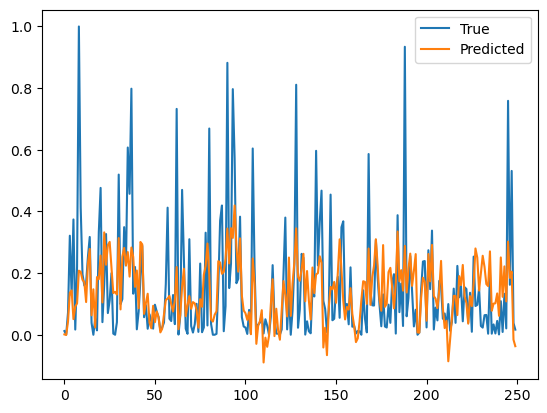

In [63]:
plt.plot(y_test, label='True')# Reshape to (batch_size, channels=2, height=121, width=409)

y_pred = model(torch.from_numpy(X_test).view(250, -1)).detach().numpy()
plt.plot(y_pred, label='Predicted')
plt.legend()